In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [10]:
df = pd.read_csv('df6.csv')

In [45]:
df2 = df.drop(['churn_score','churn_rsn_na', 'churn_rsn_competitor', 'churn_rsn_support', 'churn_rsn_price',
       'churn_rsn_product', 'churn_rsn_reloca', 'churn_rsn_unknown' ], axis=1)

In [46]:
X = df2.drop('churn_value', axis=1)
y = df2['churn_value']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [48]:
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()

In [49]:
scaler = StandardScaler().fit(X_train_2[['tenure_months', 'monthly_charges', 'total_charges', 'cltv']])

X_train_2[['tenure_months', 'monthly_charges', 'total_charges', 'cltv']] = scaler.transform(X_train_2[['tenure_months', 'monthly_charges', 'total_charges', 'cltv']])
X_test_2[['tenure_months', 'monthly_charges', 'total_charges', 'cltv']] = scaler.transform(X_test_2[['tenure_months', 'monthly_charges', 'total_charges', 'cltv']])



In [103]:
X_train_2 = X_train_2.drop(['streaming_movies', 'streaming_tv', 'tenure_4+yr', 'tenure_1-2yr', 'tenure_2-4yr',
'p1_phone_only_core', 'p3_int_only_core','p4_int_only_prem','p2_phone_only_prem'], axis=1)

In [105]:
X_test_2 = X_test_2.drop(['streaming_movies', 'streaming_tv', 'tenure_4+yr', 'tenure_1-2yr', 'tenure_2-4yr',
'p1_phone_only_core', 'p3_int_only_core','p4_int_only_prem','p2_phone_only_prem'], axis=1)

In [196]:
df2.info()

,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,...,p4_int_only_prem,p5_int_phone_bund_core,p6_int_phone_bund_prem,streams,pmt_meth_auto,num_add_ons,tenure_0-1yr,tenure_1-2yr,tenure_2-4yr,tenure_4+yr
0,0,0,0,2,1,0,1,1,0,0,...,0,0,1,0,0,2,1,0,0,0
1,0,0,1,2,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0,0,1,8,1,1,0,0,1,0,...,0,0,1,2,0,2,1,0,0,0
3,0,1,1,28,1,1,0,0,1,1,...,0,0,1,2,0,3,0,0,1,0
4,0,0,1,49,1,1,0,1,1,0,...,0,0,1,2,1,3,0,0,0,1


## Functions

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, precision_recall_curve, classification_report
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score
import imblearn.over_sampling


In [18]:
# function to create standard gridsearchCV object
def instantiate_grid(model, grid_params, refit='roc_auc'):
 
    # set common scoring metrics for use across models
    scoring = {'roc_auc': make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=False), 
               'accuracy': make_scorer(accuracy_score), 
               'precision': make_scorer(precision_score), 
               'recall': make_scorer(recall_score), 
               'f1': make_scorer(f1_score)
              }
    
    # GridSearch uses 5 cross-validation folds within each training iteration
    gs = GridSearchCV(estimator=model, param_grid=grid_params, 
                      scoring=scoring, refit=refit, 
                      cv=StratifiedKFold(n_splits=5, 
                                     shuffle=True))
    
    return gs

In [19]:
def score_pred(model_type, data_type, y_true, y_hat):

    scores = {}
    scores['model'] = model_type
    scores['data'] = data_type
    scores['auc'] = roc_auc_score(y_true, y_hat)
    scores['acc'] = accuracy_score(y_true, y_hat)
    scores['rec'] = recall_score(y_true, y_hat)
    scores['prec'] = precision_score(y_true, y_hat)
    scores['f1'] = f1_score(y_true, y_hat)   
    print(f'Model {scores["model"]} Predictions: AUC {round(scores["auc"], 2)} | '
          f'Accuracy {round(scores["acc"], 2)} | '
          f'Recall {round(scores["rec"], 2)} | '
          f'Precision {round(scores["prec"], 2)} | '
          f'F1 {round(scores["f1"], 2)}' )

    return scores

In [20]:
def decision_thresh(model, X_test, y_test):
    X_val, y_val = X_test, y_test # explicitly calling this validation since we're using it for selection

    thresh_ps = np.linspace(.10,.50,1000)
    model_val_probs = model.predict_proba(X_val)[:,1] # positive class probs, same basic logistic model we fit in section 2 

    f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
    for p in thresh_ps:
        model_val_labels = model_val_probs >= p
        f1_scores.append(f1_score(y_val, model_val_labels))    
        prec_scores.append(precision_score(y_val, model_val_labels))
        rec_scores.append(recall_score(y_val, model_val_labels))
        acc_scores.append(accuracy_score(y_val, model_val_labels))
    
    plt.plot(thresh_ps, f1_scores)
    plt.plot(thresh_ps, prec_scores)
    plt.plot(thresh_ps, rec_scores)
    plt.plot(thresh_ps, acc_scores)

    plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
    plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
    plt.xlabel('P threshold')
    plt.ylabel('Metric score')

    best_f1_score = np.max(f1_scores) 
    best_thresh_p = thresh_ps[np.argmax(f1_scores)]

    print('Model best F1 score %.3f at prob decision threshold >= %.3f' 
          % (best_f1_score, best_thresh_p))

In [21]:
def eval_metrics(model, X_test, y_test, y_pred):
    #confusion matrix
    
    print('Accuracy score test', model.score(X_test, y_test))
    c_matrix = confusion_matrix(y_test, y_pred)
    
    plt.figure(dpi=150)
    sns.heatmap(c_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model} confusion matrix')
    plt.show()
    
    print(classification_report(y_test, y_pred))

In [152]:
def feature_importance(model, X_df):

    # create feature coefficient dataframe
    coef_table = pd.DataFrame(X_df.columns, columns=['feature'])
    coef_table.insert(1, 'coef', model.coef_.transpose())

    # plot feature coefficient on bar graph
    fig = plt.figure(figsize=(18, 8))
    sns.barplot(x='feature', y='coef', data=coef_table, palette='vlag')
    plt.title('Model Coefficients by Feature', size=20)
    plt.xlabel('Feature', size=16)
    plt.ylabel('Model Coefficient', size=16)
    plt.xticks(rotation=-80)
    plt.tight_layout()
    plt.show()
    
    return coef_table.sort_values(ascending=False)

In [23]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

## MODELS

## XGBoost

In [37]:
#Oversampling
from sklearn.metrics import plot_confusion_matrix

In [76]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 2, 0 : n_neg} 

# randomly oversample positive samples: create 2x as many 



In [108]:
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio) 
    
X_train_3, y_train_3 = ROS.fit_resample(X_train_2, y_train)

In [78]:
#TRYING SMOTE
smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    
X_tr_smote, y_tr_smote = smote.fit_resample(X_train_2, y_train)

In [51]:
from xgboost import XGBClassifier

In [52]:
param_grid_xg = {
    'reg_alpha':[0.1, 1, 10],
    'learning_rate': [0.01, 0.1], # step size for model iteration
    'max_depth': [4, 8], # max number of trees deep
    'n_estimators': [100, 200, 500], # number of trees to grow
    'subsample': [0.6, 0.8] # ratio of the training used to grow each tree
}

In [109]:
gs_xg = instantiate_grid(model_xg, param_grid_xg)

In [110]:
model_xg = XGBClassifier(objective='binary:logistic') 

In [111]:
gs_xg.fit(X_train_3, y_train_3)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     miss...
                                     verbosity=None),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8],
                         'n_estimators': [100, 200, 500],
                         'reg_alpha': [0.1, 1, 10], 'subsample': [0.6, 0.8]},
             refit='roc_auc',
             scoring={'ac

XGBoost Confusion Matrix - Training Data
Best Model Parameters: 68 <bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)>


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


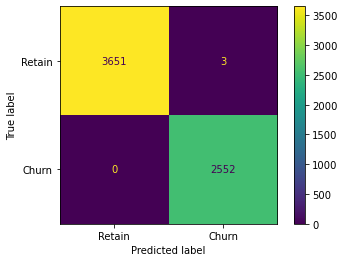

In [112]:
# print confusion matrix (train) for best model
best_model_xg = gs_xg.best_estimator_
print('XGBoost Confusion Matrix - Training Data')

plot_confusion_matrix(best_model_xg, X_train_3, y_train_3, display_labels=['Retain', 'Churn'])
print(f'Best Model Parameters: {gs_xg.best_index_} {gs_xg.best_estimator_.get_params}')

In [113]:
# compare xgboost best estimator metrics for Train vs Test data sets
print('Train Performance - XGBoost Model\n---------------------------------')
y_hat_train_3 = best_model_xg.predict(X_train_3)
scores_train_xg = score_pred('xg', 'train', y_tr_smote, y_hat_train_3)

print('\nTest Performance - XGBoost Model\n--------------------------------')
y_hat_test_3 = best_model_xg.predict(X_test_2)
scores_test_xg = score_pred('xg', 'test', y_test, y_hat_test_3)

Train Performance - XGBoost Model
---------------------------------
Model xg Predictions: AUC 1.0 | Accuracy 1.0 | Recall 1.0 | Precision 1.0 | F1 1.0

Test Performance - XGBoost Model
--------------------------------
Model xg Predictions: AUC 0.73 | Accuracy 0.79 | Recall 0.6 | Precision 0.64 | F1 0.62


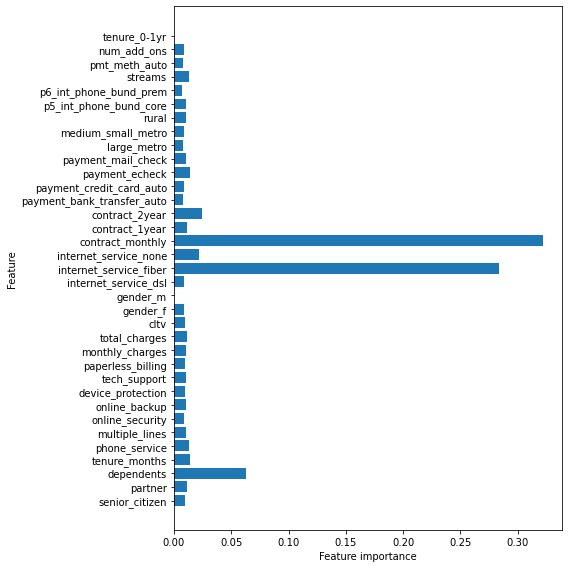

In [114]:
# plot Random Forest feature importance for best estimator
n_features = X_train_3.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), best_model_xg.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train_3.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Model best F1 score 0.646 at prob decision threshold >= 0.252


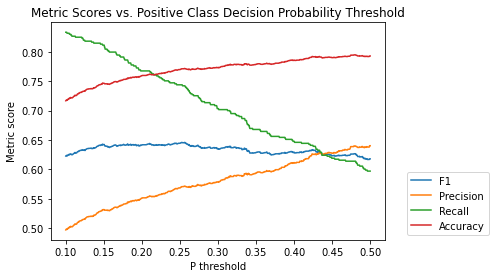

In [115]:
decision_thresh(best_model_xg, X_test_2, y_test)

In [116]:
xg_dt = 0.252

xg_predicted_proba = best_model_xg.predict_proba(X_test_2)
xg_pred = (xg_predicted_proba [:,1] >= xg_dt).astype('int')

print(confusion_matrix(y_test, xg_pred))
print(classification_report(y_test, xg_pred))
score_pred('XGBoost', 'test', y_test, xg_pred)

[[1187  333]
 [ 152  441]]
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1520
           1       0.57      0.74      0.65       593

    accuracy                           0.77      2113
   macro avg       0.73      0.76      0.74      2113
weighted avg       0.80      0.77      0.78      2113

Model XGBoost Predictions: AUC 0.76 | Accuracy 0.77 | Recall 0.74 | Precision 0.57 | F1 0.65


{'model': 'XGBoost',
 'data': 'test',
 'auc': 0.7622986376142717,
 'acc': 0.7704685281590156,
 'rec': 0.7436762225969646,
 'prec': 0.5697674418604651,
 'f1': 0.6452084857351865}

Logistic Regression Model AUC 0.762


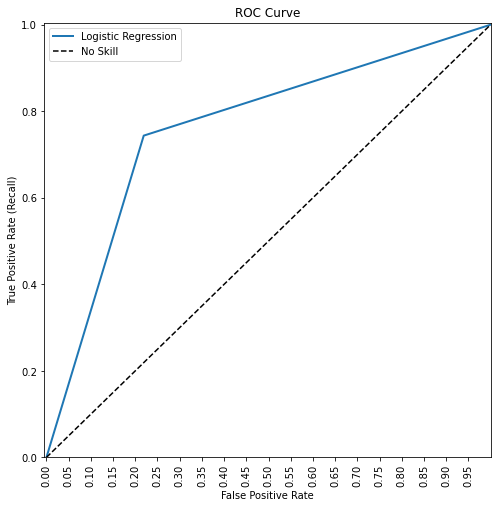

In [117]:
# plot the ROC Area Under Curve for XGBoost
fpr2, tpr2, auc_thresholds2 = roc_curve(y_test, xg_pred)
print(f'Logistic Regression Model AUC {round(auc(fpr2, tpr2), 3)}') # AUC of ROC
plot_roc_curve(fpr2, tpr2, 'Logistic Regression')

## Logistic Regression

In [118]:
#DROPPING DUMMIES
X_train_lr = X_train_3.drop(columns=['gender_f', 'internet_service_none', 'payment_credit_card_auto',
'medium_small_metro', 'contract_1year'])


X_test_lr = X_test_2.drop(columns=['gender_f', 'internet_service_none', 'payment_credit_card_auto',
'medium_small_metro', 'contract_1year'])



In [145]:
X_smote_lr = X_tr_smote.drop(columns=['gender_f', 'internet_service_none', 'payment_credit_card_auto',
'medium_small_metro', 'contract_1year'])

y_smote_lr = y_tr_smote.drop(columns=['gender_f', 'internet_service_none', 'payment_credit_card_auto',
'medium_small_metro', 'contract_1year'])


In [93]:
# create Logistic Regression classifier object
lr_model = LogisticRegression(max_iter=500)

In [94]:
# define the grid for Logistic Regression
c_params = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

grid_params_lr = [{'C' : c_params, 'solver' : ['liblinear', 'saga'], 
                   'penalty': ['l1', 'l2'], 
                   'class_weight' : [None, 'balanced', 
                                         {1:2, 0:1}, {1:3, 0:1}, {1:5, 0:1}]}]

In [119]:
gs_lr = instantiate_grid(lr_model, grid_params_lr)

In [147]:
gs_lr_2 = instantiate_grid(lr_model, grid_params_lr)

In [148]:
gs_lr_2.fit(X_smote_lr, y_smote_lr)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linea

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linea

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linea

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linea

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=LogisticRegression(max_iter=500),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'class_weight': [None, 'balanced', {0: 1, 1: 2},
                                           {0: 1, 1: 3}, {0: 1, 1: 5}],
                          'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']}],
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

In [149]:
# compare Logistic Regression best estimator metrics for Train vs Test data sets
print('Train Performance - Logistic Regression\n---------------------------------')
y_hat_train2 = gs_lr_2.predict(X_smote_lr)
scores_train_lr = score_pred('lr', 'train', y_smote_lr, y_hat_train2)

print('\nTest Performance - Logistic Regression\n--------------------------------')
y_hat_test2 = gs_lr.predict(X_test_lr)
scores_test_lr = score_pred('lr', 'test', y_test, y_hat_test2)

Train Performance - Logistic Regression
---------------------------------
Model lr Predictions: AUC 0.81 | Accuracy 0.81 | Recall 0.84 | Precision 0.74 | F1 0.78

Test Performance - Logistic Regression
--------------------------------
Model lr Predictions: AUC 0.78 | Accuracy 0.76 | Recall 0.82 | Precision 0.55 | F1 0.66


In [120]:
gs_lr.fit(X_train_lr, y_train_3)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linea

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=LogisticRegression(max_iter=500),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'class_weight': [None, 'balanced', {0: 1, 1: 2},
                                           {0: 1, 1: 3}, {0: 1, 1: 5}],
                          'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']}],
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

Logistic Regression Confusion Matrix - Training Data
Best Model Parameters: 64 <bound method BaseEstimator.get_params of LogisticRegression(C=1, class_weight='balanced', max_iter=500, penalty='l1',
                   solver='liblinear')>


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


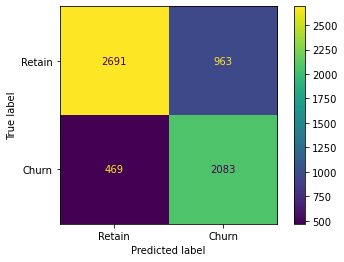

In [121]:
# print confusion matrix (train) for best model
best_model_lr = gs_lr.best_estimator_
print('Logistic Regression Confusion Matrix - Training Data')
plot_confusion_matrix(best_model_lr, X_train_lr, y_train_3, display_labels=['Retain', 'Churn'])
print(f'Best Model Parameters: {gs_lr.best_index_} {gs_lr.best_estimator_.get_params}')

In [154]:
# compare Logistic Regression best estimator metrics for Train vs Test data sets
print('Train Performance - Logistic Regression\n---------------------------------')
y_hat_train2 = best_model_lr.predict(X_train_lr)
scores_train_lr = score_pred('lr', 'train', y_train_3, y_hat_train2)

print('\nTest Performance - Logistic Regression\n--------------------------------')
y_hat_test2 = best_model_lr.predict(X_test_lr)
scores_test_lr = score_pred('lr', 'test', y_test, y_hat_test2)

Train Performance - Logistic Regression
---------------------------------
Model lr Predictions: AUC 0.78 | Accuracy 0.77 | Recall 0.82 | Precision 0.68 | F1 0.74

Test Performance - Logistic Regression
--------------------------------
Model lr Predictions: AUC 0.78 | Accuracy 0.76 | Recall 0.82 | Precision 0.55 | F1 0.66


In [166]:
coef_table_lr = pd.DataFrame(X_train_lr.columns, columns=['feature'])
coef_table_lr.insert(1, 'coef', best_model_lr.coef_.transpose())
coef_table_lr = coef_table_lr.sort_values('coef', ascending=False)

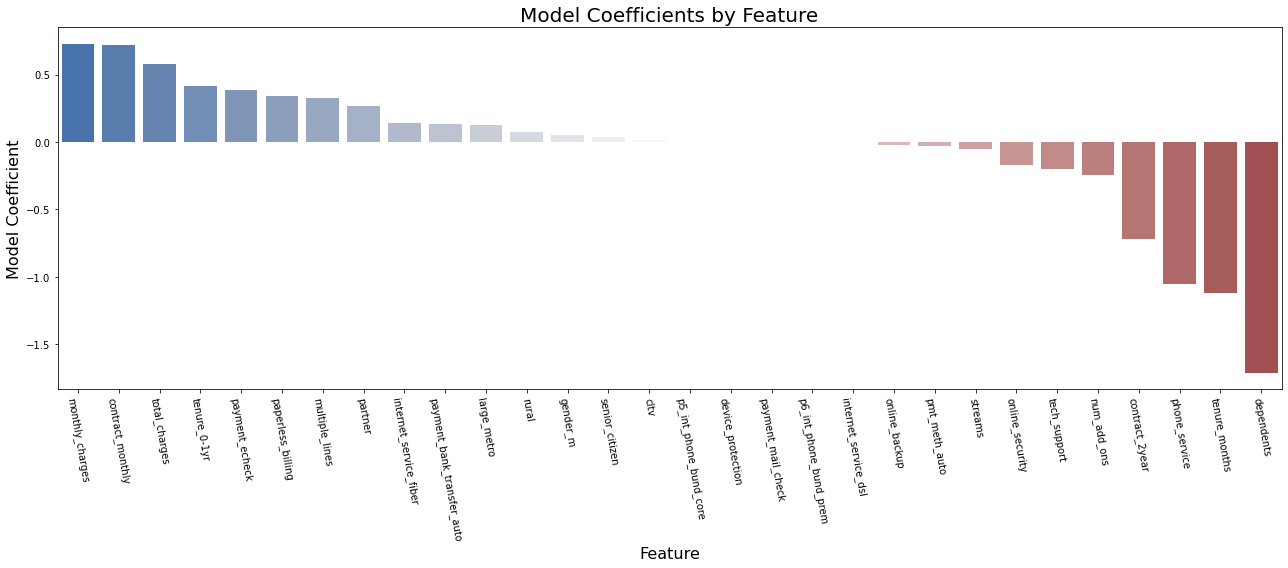

In [167]:
fig = plt.figure(figsize=(18, 8))
sns.barplot(x='feature', y='coef', data=coef_table_lr, palette='vlag')
plt.title('Model Coefficients by Feature', size=20)
plt.xlabel('Feature', size=16)
plt.ylabel('Model Coefficient', size=16)
plt.xticks(rotation=-80)
plt.tight_layout()
plt.show()

In [193]:
#top ten positive
coef_sorted = coef_table_lr.iloc[(-coef_table_lr.coef.abs()).argsort()].head(20)
coef_sorted
#coef_table_lr[coef_table_lr['coef'].abs>0].head(10)

,feature,coef
2,dependents,-1.712873
3,tenure_months,-1.119910
4,phone_service,-1.053785
11,monthly_charges,0.727434
17,contract_monthly,0.719693
18,contract_2year,-0.719140
12,total_charges,0.578364
29,tenure_0-1yr,0.412914
20,payment_echeck,0.386697
10,paperless_billing,0.337893


In [195]:
coef_sorted_df = pd.DataFrame({'feature': [x for x in coef_sorted.feature], 'odds %': [((np.exp(x) - 1) * 100) for x in coef_sorted.coef]})
coef_sorted_df

,feature,odds %
0,dependents,-81.965309
1,tenure_months,-67.369084
2,phone_service,-65.138420
3,monthly_charges,106.976342
4,contract_monthly,105.380266
5,contract_2year,-51.282878
6,total_charges,78.311834
7,tenure_0-1yr,51.121574
8,payment_echeck,47.211074
9,paperless_billing,40.199064


In [ ]:
#['gender_f', 'internet_service_none', 'payment_credit_card_auto',
# 'medium_small_metro', 'contract_1year']) - baseline.

# 1. Demographics: Dependents: customers who don't have dependents are more likely to churn by roughly 20%.
# 2. Tenure in months: Monthly customer are 106% more likely to churn than 1 year contracts.
# And 2 year contracts are 51% less likely to churn in a given quarter.
# 2. Tenure: within their first year, with hot range within 5 months (graph).
# 3. Product: customers who have single phone service are less likely to churn by ~65%.
# 4. Fiber internet increases the churn by alsmot 15%.
# 5. 

# NUM OF ADD ONS:
#Going up from 1 level of smoking to the next multiplies the odds of heart disease by 1.46.

#Customers to look out for:
#Profile of most likely to churn:
# 1. Contract: Monthly contract --> odds of churn increase by ~106%
# 2. Tenure: within their first year, with hot range within 5 months (graph).
# 
# 3. Demo: No dependents --> increase 
# 4. Paperless billing/echeck
# 5. Product: no phone service, no add ons.
#Overall: the more services they are signed up for the less likely they are to churn.
#But with the phone, multiline clients are volatile. 

#Best combo to incentivize:

#1. 


In [172]:
#top ten negative
coef_table_lr[coef_table_lr['coef']<0].head(10)

,feature,coef
7,online_backup,-0.020617
27,pmt_meth_auto,-0.032589
26,streams,-0.051886
6,online_security,-0.167549
9,tech_support,-0.204182
28,num_add_ons,-0.244629
18,contract_2year,-0.719140
4,phone_service,-1.053785
3,tenure_months,-1.119910
2,dependents,-1.712873


In [185]:
X_test_lr[['tenure_months', 'monthly_charges', 'total_charges', 'cltv']].describe()

,tenure_months,monthly_charges,total_charges,cltv
count,2113.000000,2113.000000,2113.000000,2113.000000
mean,-0.031988,-0.004463,-0.016913,0.004309
std,0.998850,0.999239,0.998911,0.990967
min,-1.327355,-1.528465,-1.010484,-2.019596
25%,-1.001693,-0.986880,-0.836965,-0.764389
50%,-0.228244,0.182677,-0.401964,0.122433
75%,0.911574,0.830586,0.587753,0.816212
max,1.603607,1.792480,2.819693,1.771315


In [188]:
X_test[['tenure_months', 'monthly_charges', 'total_charges', 'cltv']].describe()

,tenure_months,monthly_charges,total_charges,cltv
count,2113.000000,2113.000000,2113.000000,2113.000000
mean,31.821107,64.667676,2252.890156,4403.873639
std,24.537062,30.073944,2264.997300,1175.542920
min,0.000000,18.800000,0.000000,2003.000000
25%,8.000000,35.100000,393.450000,3492.000000
50%,27.000000,70.300000,1379.800000,4544.000000
75%,55.000000,89.800000,3623.950000,5367.000000
max,72.000000,118.750000,8684.800000,6500.000000


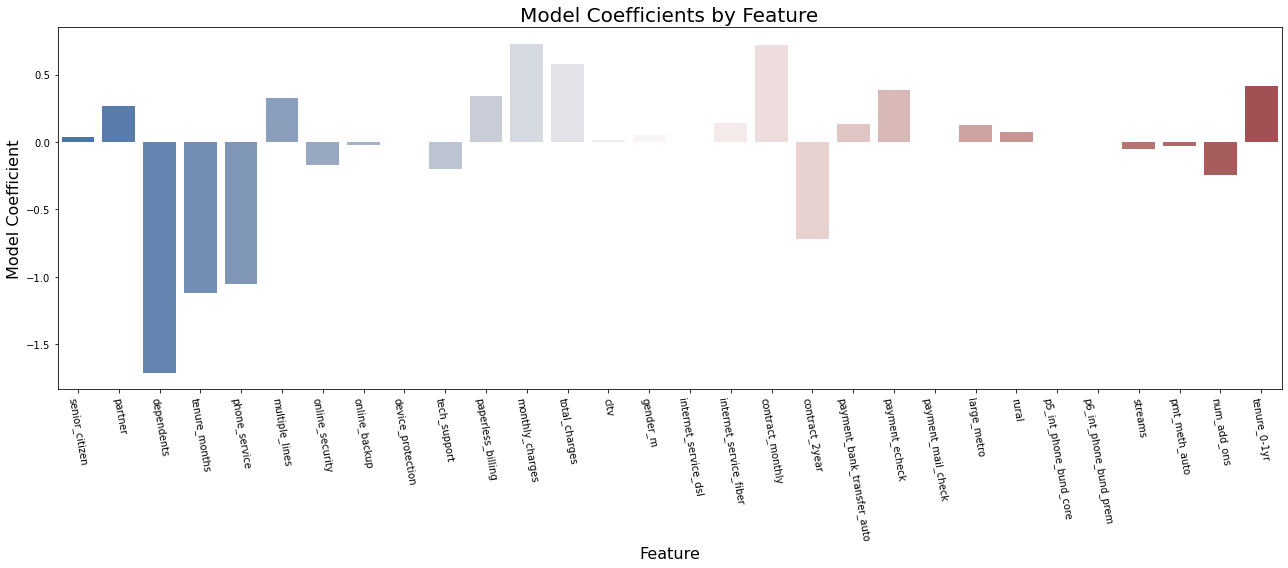

,feature,coef
0,senior_citizen,0.034425
1,partner,0.264900
2,dependents,-1.712873
3,tenure_months,-1.119910
4,phone_service,-1.053785
5,multiple_lines,0.325659
6,online_security,-0.167549
7,online_backup,-0.020617
8,device_protection,0.000000
9,tech_support,-0.204182


In [123]:
feature_importance(best_model_lr, X_train_lr)

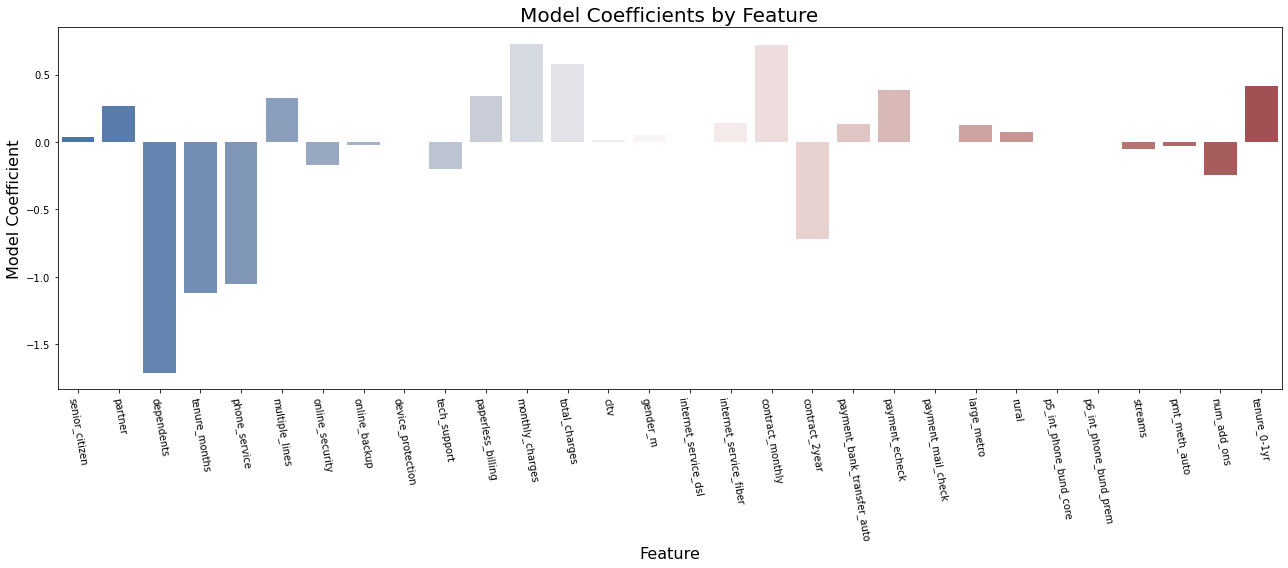

TypeError: sort_values() missing 1 required positional argument: 'by'

In [153]:
feature_importance(best_model_lr, X_train_lr)

Logistic Regression Confusion Matrix - Test Data - Best Model 64
Accuracy score test 0.7586370089919545


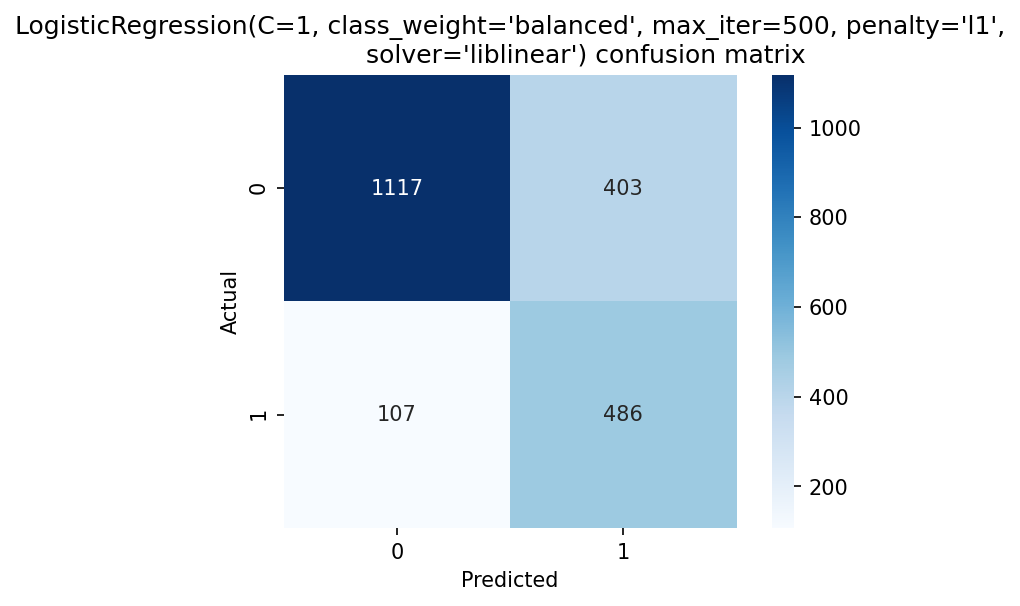

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1520
           1       0.55      0.82      0.66       593

    accuracy                           0.76      2113
   macro avg       0.73      0.78      0.74      2113
weighted avg       0.81      0.76      0.77      2113



In [124]:
# print confusion matrix for best Logistic Regression model on test data
best_model_lr = gs_lr.best_estimator_
print(f'Logistic Regression Confusion Matrix - Test Data - Best Model {gs_lr.best_index_}')

eval_metrics(best_model_lr, X_test_lr, y_test, y_hat_test2)
# plot_confusion_matrix(best_model_lr, X_test_3, y_test, display_labels=['Retain', 'Churn'])

# display_class_report(y_test, y_hat_test2)

Model best F1 score 0.657 at prob decision threshold >= 0.490


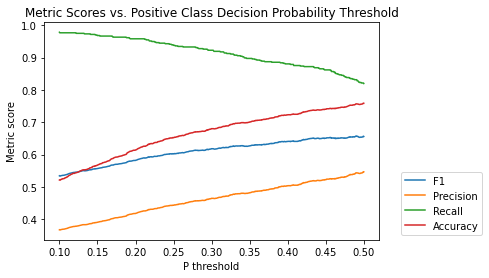

In [125]:
decision_thresh(best_model_lr, X_test_lr, y_test)

In [126]:
lr_dt = 0.490

lr_predicted_proba = best_model_lr.predict_proba(X_test_lr)
lr_pred = (lr_predicted_proba [:,1] >= lr_dt).astype('int')

print(confusion_matrix(y_test, lr_pred))
print(classification_report(y_test, lr_pred))
score_pred('Logistic Regression', 'test', y_test, lr_pred)

[[1106  414]
 [ 100  493]]
              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1520
           1       0.54      0.83      0.66       593

    accuracy                           0.76      2113
   macro avg       0.73      0.78      0.73      2113
weighted avg       0.81      0.76      0.77      2113

Model Logistic Regression Predictions: AUC 0.78 | Accuracy 0.76 | Recall 0.83 | Precision 0.54 | F1 0.66


{'model': 'Logistic Regression',
 'data': 'test',
 'auc': 0.779498757433212,
 'acc': 0.7567439659252247,
 'rec': 0.8313659359190556,
 'prec': 0.5435501653803748,
 'f1': 0.6573333333333333}

In [169]:
lr_predicted_proba

array([[0.33506078, 0.66493922],
       [0.6892227 , 0.3107773 ],
       [0.85834254, 0.14165746],
       ...,
       [0.39989913, 0.60010087],
       [0.57555757, 0.42444243],
       [0.13252681, 0.86747319]])

Logistic Regression Model AUC 0.779


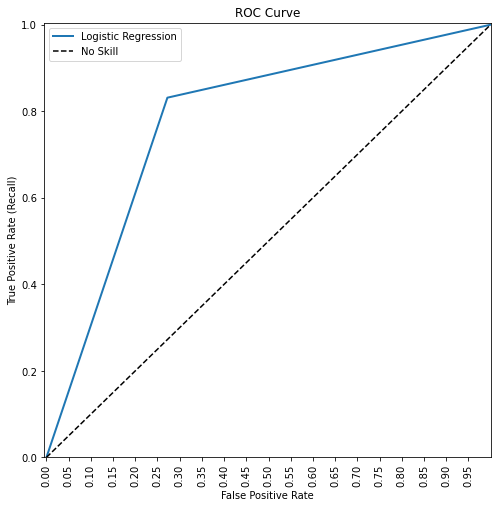

In [127]:
fpr2, tpr2, auc_thresholds2 = roc_curve(y_test, lr_pred)
print(f'Logistic Regression Model AUC {round(auc(fpr2, tpr2), 3)}') # AUC of ROC
plot_roc_curve(fpr2, tpr2, 'Logistic Regression')

## Random Forest - reg

In [128]:
model_rf = RandomForestClassifier()

In [129]:
grid_params_rf = [{#'criterion': ['gini', 'entropy'], # measures split quality
                   'class_weight' : [None, 'balanced', 
                                         {1:2, 0:1}, {1:3, 0:1}, {1:5, 0:1}], # adjust imbalanced positive class
                   'n_estimators': [100, 200, 500], # number trees to grow            
                   #'max_features': ['auto', 6], # features considered at splits
                   'max_depth': [4, 8, 10],  # max nodes in each tree
                   #'min_samples_leaf': [5, 10, 15], # samples required in each leaf
                   'min_samples_split': [0.1, 0.2, 0.3], # percentage required to split node
                    }]

In [130]:
gs_rf = instantiate_grid(model_rf, grid_params_rf)

In [131]:
gs_rf.fit(X_train_3, y_train_3)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid=[{'class_weight': [None, 'balanced', {0: 1, 1: 2},
                                           {0: 1, 1: 3}, {0: 1, 1: 5}],
                          'max_depth': [4, 8, 10],
                          'min_samples_split': [0.1, 0.2, 0.3],
                          'n_estimators': [100, 200, 500]}],
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

Random Forest Confusion Matrix - Training Data


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Best Model Parameters: 47 <bound method BaseEstimator.get_params of RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=0.1, n_estimators=500)>


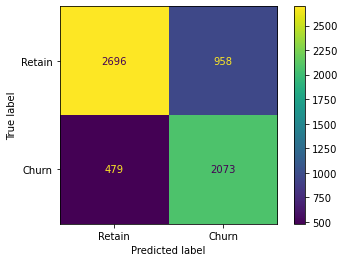

In [133]:
# print confusion matrix (train) for best model
best_model_rf = gs_rf.best_estimator_
print('Random Forest Confusion Matrix - Training Data')

plot_confusion_matrix(best_model_rf, X_train_3, y_train_3, display_labels=['Retain', 'Churn'])
print(f'Best Model Parameters: {gs_rf.best_index_} {gs_rf.best_estimator_.get_params}')



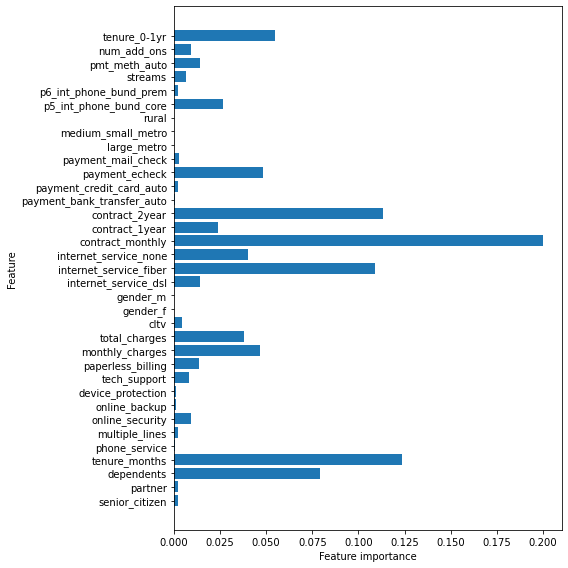

In [134]:
# plot Random Forest feature importance for best estimator
n_features = X_train_3.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), best_model_rf.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train_3.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [137]:
# compare random forest best estimator metrics for Train vs Test data sets
print('Train Performance - Random Forest\n---------------------------------')
y_hat_train3 = gs_rf.predict(X_train_3)
scores_train_rf = score_pred('rf', 'train', y_train_3, y_hat_train3)

print('\nTest Performance - Random Forest\n--------------------------------')
y_hat_test3 = gs_rf.predict(X_test_2)
scores_test_rf = score_pred('rf', 'test', y_test, y_hat_test3)

Train Performance - Random Forest
---------------------------------
Model rf Predictions: AUC 0.78 | Accuracy 0.77 | Recall 0.81 | Precision 0.68 | F1 0.74

Test Performance - Random Forest
--------------------------------
Model rf Predictions: AUC 0.77 | Accuracy 0.76 | Recall 0.82 | Precision 0.54 | F1 0.65


Random Forest Confusion Matrix - Test Data - Best Model 47
Accuracy score test 0.7557974443918599


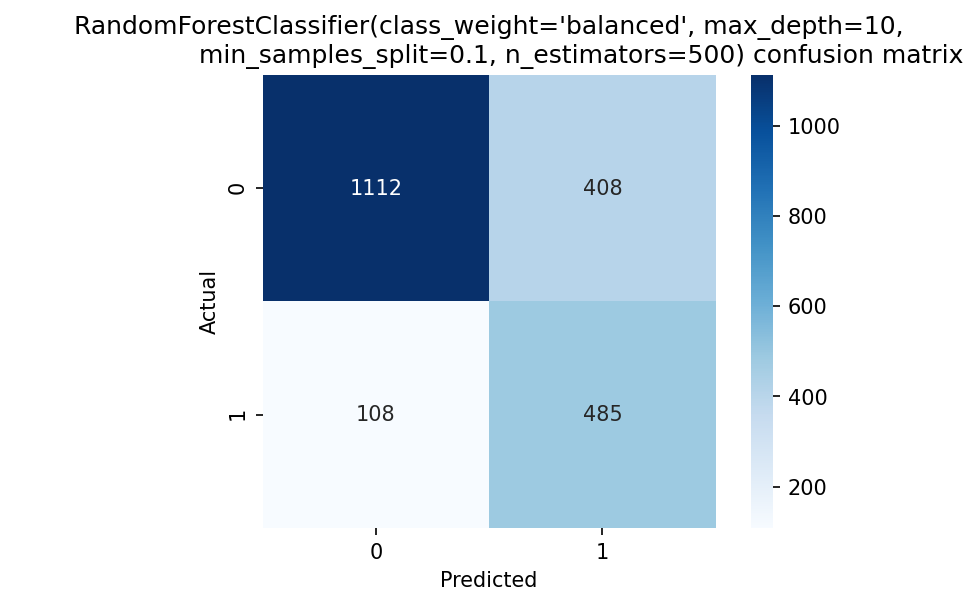

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1520
           1       0.54      0.82      0.65       593

    accuracy                           0.76      2113
   macro avg       0.73      0.77      0.73      2113
weighted avg       0.81      0.76      0.77      2113



In [139]:
# print confusion matrix for best random forest model on test data
best_model_rf = gs_rf.best_estimator_
print(f'Random Forest Confusion Matrix - Test Data - Best Model {gs_rf.best_index_}')


eval_metrics(best_model_rf, X_test_2, y_test, y_hat_test3)

Model best F1 score 0.653 at prob decision threshold >= 0.499


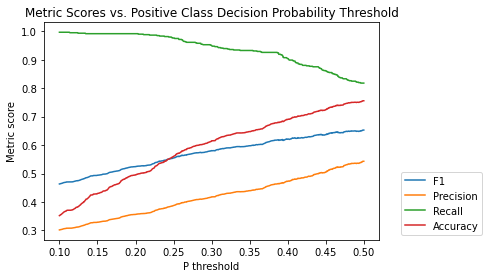

In [142]:
decision_thresh(best_model_rf, X_test_2, y_test)

In [143]:
rf_dt = 0.499

rf_predicted_proba = best_model_rf.predict_proba(X_test_2)
rf_pred = (rf_predicted_proba [:,1] >= rf_dt).astype('int')

print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))
score_pred('Random Forest', 'test', y_test, rf_pred)

[[1112  408]
 [ 108  485]]
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1520
           1       0.54      0.82      0.65       593

    accuracy                           0.76      2113
   macro avg       0.73      0.77      0.73      2113
weighted avg       0.81      0.76      0.77      2113

Model Random Forest Predictions: AUC 0.77 | Accuracy 0.76 | Recall 0.82 | Precision 0.54 | F1 0.65


{'model': 'Random Forest',
 'data': 'test',
 'auc': 0.7747270790805006,
 'acc': 0.7557974443918599,
 'rec': 0.8178752107925801,
 'prec': 0.5431131019036954,
 'f1': 0.6527590847913863}

Logistic Regression Model AUC 0.775


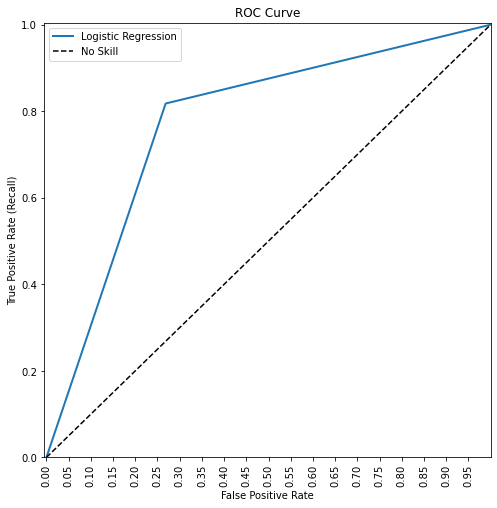

In [144]:
# plot the ROC Area Under Curve for Random Forest
fpr2, tpr2, auc_thresholds2 = roc_curve(y_test, rf_pred)
print(f'Logistic Regression Model AUC {round(auc(fpr2, tpr2), 3)}') # AUC of ROC
plot_roc_curve(fpr2, tpr2, 'Logistic Regression')

## STATS MODELS LOGIT

In [159]:
import statsmodels.api as sm
import pandas as pd
 
# loading the training dataset

lr_sm_model = sm.Logit(X_train_lr, y_train_3).fit()
#gs_lr_sm = instantiate_grid(lr_sm_model, grid_params_lr)
lr_sm_model.summary()
# building the model and fitting the data
#sm_lr = sm.Logit(ytrain, Xtrain).fit()

ValueError: endog must be in the unit interval.

In [164]:
y_train_3.isnull().sum()

array([0, 1])